# Capital Bike Share Prediction #

 - Used the data provided by Kaggle and Capital Bike share combined with weather data from DarkSky for years '11, '12, '15, '16
 - In order to test in an unbiased manner, I have done a train_test split on the '15-'16 data the way that it was done for Kaggle challenge (i.e. took out the last 5 days of each month).
 
- Ran 4 models as outlined below. Best MSE is achieved by RF_Regressor among all models.

- Used only 3 features (though intended for more in the beginning but filtered out via assessing Feature Importances)

- Created a .py file that can run from Terminal for any data given the format is the same.

## Improvements to be done ##

- Create a .py file for train-test split and streamlining data handling



|  Mode    |    MSE Score  |
|----------|---------------|
| LinReg   |     1.32      |
| Lasso    |     1.33      | 
| Ridge    |     1.33      | 
| RF_Reg   |     0.56      | 

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import probplot


In [2]:
df_train = pd.read_csv('./bike_15_16_12_11_train.csv', index_col = 0)

# Inspect the Training Data #

In [3]:
df_train.head()

,count,Hour,Day,Month,Year,atemp,humidity,temp,windspeed,Day_Name,workingday,holiday,season
2015-01-01 00:00:00-05:00,54,0,1,1,2015,-4.02,67.0,-4.02,0.04,Thursday,1,0,1
2015-01-01 01:00:00-05:00,114,1,1,1,2015,-4.30,70.0,-4.30,0.43,Thursday,1,0,1
2015-01-01 02:00:00-05:00,100,2,1,1,2015,-4.09,67.0,-4.09,0.57,Thursday,1,0,1
2015-01-01 03:00:00-05:00,16,3,1,1,2015,-3.86,64.0,-3.86,0.55,Thursday,1,0,1
2015-01-01 04:00:00-05:00,8,4,1,1,2015,-4.27,64.0,-4.27,0.47,Thursday,1,0,1


# EDA #

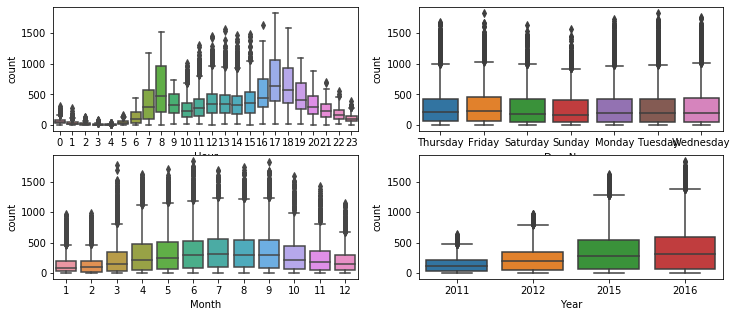

In [4]:
plt.figure(figsize = (12,5))
plt.subplot(2,2,1) # r, c, fignum
sns.boxplot(y = df_train['count'], x = df_train['Hour'])
plt.subplot(2,2,2) # r, c, fignum
sns.boxplot(y = df_train['count'], x = df_train['Day_Name'])
plt.subplot(2,2,3) # r, c, fignum
sns.boxplot(y = df_train['count'], x = df_train['Month'])
plt.subplot(2,2,4) # r, c, fignum
sns.boxplot(y = df_train['count'], x = df_train['Year'])

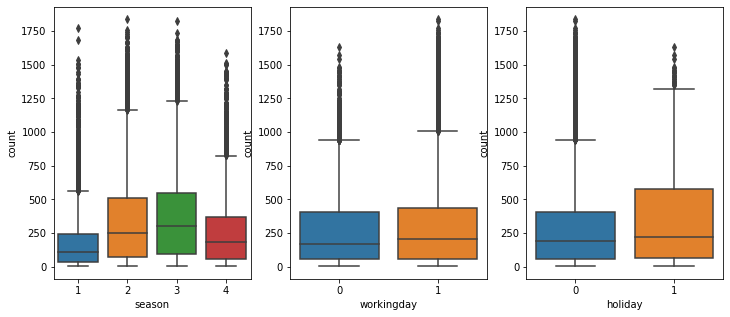

In [5]:
plt.figure(figsize = (12,5))
plt.subplot(1,3,1) # r, c, fignum
sns.boxplot(y = df_train['count'], x = df_train['season'])
plt.subplot(1,3,2) # r, c, fignum
sns.boxplot(y = df_train['count'], x = df_train['workingday'])
plt.subplot(1,3,3) # r, c, fignum
sns.boxplot(y = df_train['count'], x = df_train['holiday'])


## What have we learned? ##
- Hour can be binned in non-equal bin sizes to yield linearly ordered sums
- 'Day of the week' doesn't matter for total count of bikes
- Month has a slight polynomial 
- Year is linearly increasing on the mean (NOT in the median because of outliers)
- Season can also be modeled as polynomial
- Workday and holiday are redundant and can be tossed anyway

# Feature Engineering #

In [6]:
#Hour Binning
hour_range = range(0,24)
bins = ['Night']*4 + ['Morning']*5 + ['Day']*7 + ['Evening']*8
hour_new = dict(zip(hour_range, bins))
df_train['Hour_binned'] = df_train['Hour'].map(hour_new)

#Hour_Dict_Factorization_Low Level
factor_hour = {'Night': 0, 'Morning':1, 'Day': 2, 'Evening': 3}
df_train['Hour_Reconvert'] = df_train['Hour_binned'].map(factor_hour)
df_train.groupby('Hour_Reconvert')['count'].count()

Hour_Reconvert
0    3859
1    4902
2    6906
3    7894
Name: count, dtype: int64

### Question : What can be the problem with hour binning? ###

In [7]:
# Pre-fitting both categoricals with polynomials
pipeline = make_pipeline(
    PolynomialFeatures(degree=2),
    LinearRegression()
)
pipeline.fit(df_train[['Month']], df_train[['count']])

Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

In [8]:
pipeline.score(df_train[['Month']], df_train[['count']])

0.07138000917507448

### Month score jumped from .012 to .071 by poly fit degree 2

In [9]:
# Pre-fitting both categoricals with polynomials
pipeline = make_pipeline(
    PolynomialFeatures(degree=2),
    LinearRegression()
)
pipeline.fit(df_train[['season']], df_train[['count']])

Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

In [10]:
pipeline.score(df_train[['season']], df_train[['count']])

0.06559995535131458

### Season score jumped from .012 to .065 by poly fit degree 2


In [11]:
df_train['Month_Poly2'] = df_train['Month']**2
df_train['season_Poly2'] = df_train['season']**2

In [12]:
df_train.columns

Index(['count', 'Hour', 'Day', 'Month', 'Year', 'atemp', 'humidity', 'temp',
       'windspeed', 'Day_Name', 'workingday', 'holiday', 'season',
       'Hour_binned', 'Hour_Reconvert', 'Month_Poly2', 'season_Poly2'],
      dtype='object')

## Train Data Split to Cat and Num ## 

In [13]:
#Separate Categorical and Numerical Columns

num_list = ['count', 'atemp', 'humidity', 'temp', 'windspeed'] # Numeric All
num_nows = ['count', 'atemp', 'humidity', 'temp'] # Numeric No windspeed
cat_list = df_train.columns.drop(num_list).tolist() # Categorical but in fact has flattened numerics inside

## Numerical Data FE ##

In [14]:
df_train[num_list].head()

,count,atemp,humidity,temp,windspeed
2015-01-01 00:00:00-05:00,54,-4.02,67.0,-4.02,0.04
2015-01-01 01:00:00-05:00,114,-4.30,70.0,-4.30,0.43
2015-01-01 02:00:00-05:00,100,-4.09,67.0,-4.09,0.57
2015-01-01 03:00:00-05:00,16,-3.86,64.0,-3.86,0.55
2015-01-01 04:00:00-05:00,8,-4.27,64.0,-4.27,0.47


### Plot the distributions ###

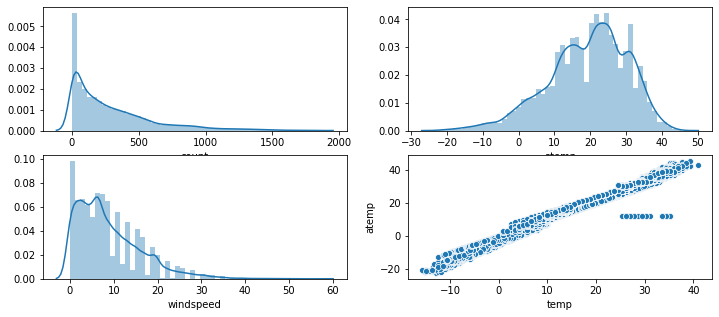

In [15]:
plt.figure(figsize = (12,5))
plt.subplot(2,2,1) # r, c, fignum
sns.distplot(df_train['count'])
plt.subplot(2,2,2) # r, c, fignum
sns.distplot(df_train['atemp'])
plt.subplot(2,2,3) # r, c, fignum
sns.distplot(df_train['windspeed'])
plt.subplot(2,2,4) # r, c, fignum
sns.scatterplot(x= df_train['temp'], y = df_train['atemp'])

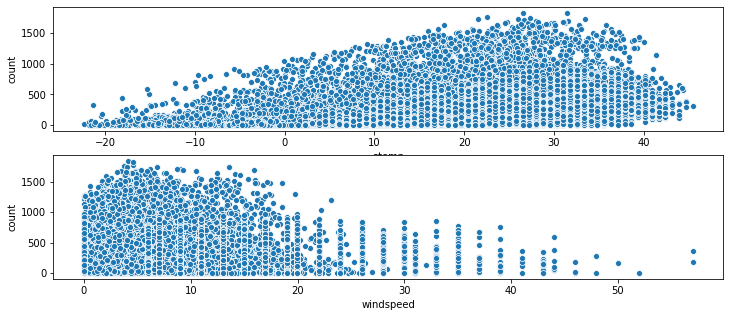

In [16]:
plt.figure(figsize = (12,5))
plt.subplot(2,1,1)
sns.scatterplot(x= df_train['atemp'], y = df_train['count'])
plt.subplot(2,1,2)
sns.scatterplot(x= df_train['windspeed'], y = df_train['count'])


### Toss the windspeed. Linearity will be hard to achieve ###

## Decision on What Type of Scaling to Do: ##
- Since I inferred meanings from all variables on mean, (except hour and year), outliers are accounted for
- Moreover, I do not want to give up on the underlying distribution
- Chosen: MinMaxScaler()

## Question: What is the danger here? ##

In [17]:
Xtrain_nonscaled = df_train[['Year', 'atemp', 'Hour']]
ytrain_nonscaled = df_train['count']


In [18]:
#Scale the Numerical Variables
sc = MinMaxScaler()
Xtrain_sc= sc.fit_transform(Xtrain_nonscaled)
Xtrain_sc = pd.DataFrame(Xtrain_sc, columns = Xtrain_nonscaled.columns)
#Take log1p of the target var
ytrain_sc = np.log1p(ytrain_nonscaled)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [19]:
#Random Forest
rf = RandomForestRegressor()
rf_param = { 'max_depth': [1, 5, 8, 32],#, 8, 32, 128, None],
    'n_estimators': [10, 100]}#, 100, 1000, 1000]}

grid_rf= GridSearchCV(rf,rf_param,scoring = 'neg_mean_squared_error',cv=5)
grid_rf.fit( Xtrain_sc, ytrain_sc)
ypred = grid_rf.predict(Xtrain_sc)
print (grid_rf.best_params_)


best_score = (grid_rf.best_score_)*-1
print('Mean Square Error is : ',best_score)


{'max_depth': 8, 'n_estimators': 100}
Mean Square Error is :  0.5601531983763366


Index(['Year', 'atemp', 'Hour'], dtype='object') [0.08482456 0.09028512 0.82489032]


<BarContainer object of 3 artists>

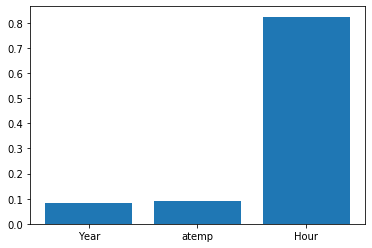

In [20]:
rf = RandomForestRegressor(max_depth = 8, n_estimators=100)
rf.fit(Xtrain_sc, ytrain_sc)

feature_label = Xtrain_nonscaled.columns
feature_importance =rf.feature_importances_

print(feature_label,feature_importance)
plt.bar(feature_label,feature_importance)

0.000832458125409113


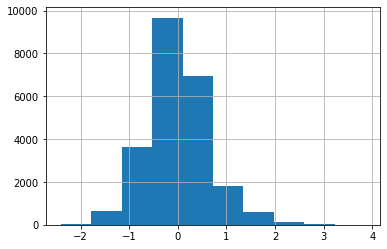

In [21]:
#Check the assumptions
#Mean residual is around zero
residuals = ypred - ytrain_sc
print(residuals.mean())
residuals.hist()

((array([-4.01742459, -3.80323536, -3.68611524, ...,  3.68611524,
          3.80323536,  4.01742459]),
  array([-2.40948061, -2.35023202, -2.30829632, ...,  3.36953547,
          3.47584521,  3.85414624])),
 (0.6308194359135156, 0.000832458125409333, 0.9883006328579634))

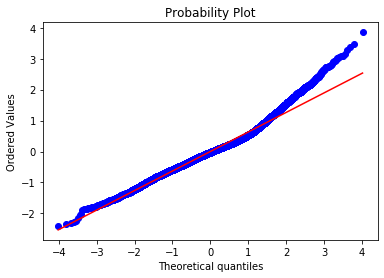

In [22]:
#Q-Q plot
probplot(residuals, plot=plt)

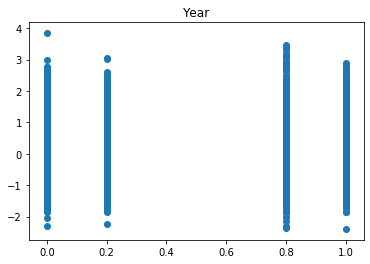

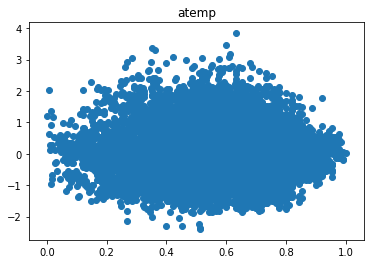

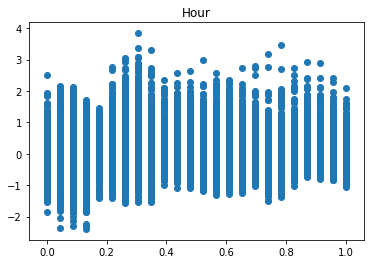

In [23]:
#Residuals uncorrelated with x and must be equally on and under 0

for column in Xtrain_sc.columns:
    plt.scatter(Xtrain_sc[column], residuals)
    plt.title(f'{column}')
    plt.show()

##  Construct a Results DF ##

In [24]:
#Results DF
a = pd.DataFrame(ytrain_nonscaled)
ypred_back = np.expm1(ypred)
a['datetime'] = ytrain_nonscaled.index
ypred_back = ypred_back.astype(int)
a['Prediction'] = ypred_back[:]


In [25]:
a.head()

,count,datetime,Prediction
2015-01-01 00:00:00-05:00,54,2015-01-01 00:00:00-05:00,25
2015-01-01 01:00:00-05:00,114,2015-01-01 01:00:00-05:00,17
2015-01-01 02:00:00-05:00,100,2015-01-01 02:00:00-05:00,10
2015-01-01 03:00:00-05:00,16,2015-01-01 03:00:00-05:00,4
2015-01-01 04:00:00-05:00,8,2015-01-01 04:00:00-05:00,3


## Calculate RMSLE ##

In [26]:
ms = (np.log1p(a['Prediction'])-np.log1p(a['count']))**2
s = np.sum(ms)
msle = s/len(a['Prediction'])
rmsle = np.sqrt(msle)
print('RMSLE is:', rmsle)

RMSLE is: 0.63833417749474


## Save to CSV ##

In [27]:
a.to_csv(f'{namelist[0]}_Predictions.csv', index_label = 'datetime')


NameError: name 'namelist' is not defined